# 1.2 Percent Change and IQR Filtering

## Description
Calculates percent change in gene counts from 2016 to 2024,
classifies genes as stable vs added, adds GO hierarchy metrics,
and filters GO terms using IQR thresholds.

## Inputs
- `output/intermediate/common_go_terms.csv`
- `output/intermediate/hetio_bppg_2016.csv`
- `output/intermediate/upd_go_bp_2024.csv`

## Outputs
- `output/intermediate/hetio_bppg_2016_stable.csv` (2016 GO-gene pairs, stable genes only)
- `output/intermediate/upd_go_bp_2024_added.csv` (2024 GO-gene pairs, added genes only)
- `output/intermediate/go_gene_classification_summary.csv` (classification statistics per GO term)
- `output/intermediate/dataset1_all_growth.csv`
- `output/intermediate/dataset2_parents.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy import stats
from pathlib import Path

# Setup repo root for consistent paths
# Works whether notebook is run from repo root or notebooks/ subdirectory
if Path.cwd().name == "notebooks":
    repo_root = Path("..").resolve()
else:
    repo_root = Path.cwd()

sys.path.insert(0, str(repo_root))
from src.go_processing import (
    calculate_percent_change,
    add_hierarchy_metrics,
    identify_leaf_terms,
    identify_parent_terms,
    classify_genes_stable_added
)
from src.filtering import (
    calculate_iqr_thresholds,
    filter_go_terms_iqr
)

print(f"Repo root: {repo_root}")

Repo root: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/multi-dwpc


In [2]:
com_go_terms_hetio_upd_go_bp_2024 = pd.read_csv(
    repo_root / 'output/intermediate/common_go_terms.csv'
)

print(f'Loaded {len(com_go_terms_hetio_upd_go_bp_2024)} GO terms')

Loaded 9760 GO terms


### Gene Classification: Stable vs Added

Classification is per GO-term-gene pair (a gene may be stable for one GO term but added for another):
- **Stable**: GO-gene pair present in both 2016 AND 2024 annotations
- **Added**: GO-gene pair only in 2024 (gene existed in Hetionet 2016, but was not annotated to this GO term)

This creates separate datasets:
- 2016 stable genes (baseline - genes with consistent annotations)
- 2024 added genes (genes newly annotated to GO terms between 2016-2024)

**Research question**: Do newly annotated GO-gene pairs show similar connectivity patterns to stable pairs, while both differ from random permutations?

In [3]:
print("Loading gene-level data for classification...")
print("=" * 60)

genes_2016 = pd.read_csv(repo_root / 'output/intermediate/hetio_bppg_2016.csv')
genes_2024 = pd.read_csv(repo_root / 'output/intermediate/upd_go_bp_2024.csv')

print(f"2016 GO-gene pairs: {len(genes_2016):,}")
print(f"2024 GO-gene pairs: {len(genes_2024):,}")
print(f"2016 unique GO terms: {genes_2016['go_id'].nunique()}")
print(f"2024 unique GO terms: {genes_2024['go_id'].nunique()}")
print(f"2016 unique genes: {genes_2016['entrez_gene_id'].nunique()}")
print(f"2024 unique genes: {genes_2024['entrez_gene_id'].nunique()}")

Loading gene-level data for classification...


2016 GO-gene pairs: 554,590
2024 GO-gene pairs: 475,630


2016 unique GO terms: 11381
2024 unique GO terms: 9760
2016 unique genes: 14173
2024 unique genes: 14173


In [4]:
print("Classifying genes...")
genes_2016_stable, genes_2024_added, classification_summary = \
    classify_genes_stable_added(genes_2016, genes_2024)

print("\nGene Classification Results")
print("=" * 60)
print(f"2016 stable pairs: {len(genes_2016_stable):,}")
print(f"2024 added pairs: {len(genes_2024_added):,}")
print(f"GO terms analyzed: {len(classification_summary)}")
print(f"\nStable genes (unique): {genes_2016_stable['entrez_gene_id'].nunique()}")
print(f"Added genes (unique): {genes_2024_added['entrez_gene_id'].nunique()}")

Classifying genes...



Gene Classification Results
2016 stable pairs: 314,466
2024 added pairs: 161,164
GO terms analyzed: 11381

Stable genes (unique): 13657
Added genes (unique): 10937


In [5]:
print("Classification Summary Statistics")
print("=" * 60)
print(f"\nMean genes per GO term:")
print(f"  2016: {classification_summary['n_genes_2016'].mean():.1f}")
print(f"  2024: {classification_summary['n_genes_2024'].mean():.1f}")
print(f"  Stable: {classification_summary['n_stable'].mean():.1f}")
print(f"  Added: {classification_summary['n_added'].mean():.1f}")

print(f"\nMedian percent of genes:")
print(f"  Stable: {classification_summary['pct_stable'].median():.1f}%")
print(f"  Added: {classification_summary['pct_added'].median():.1f}%")

# Create GO term name lookup from 2024 data
go_name_lookup = genes_2024[['go_id', 'go_name']].drop_duplicates()

print(f"\nTop 10 GO terms by number of added genes:")
top_added = classification_summary.nlargest(10, 'n_added')[
    ['go_id', 'n_genes_2024', 'n_stable', 'n_added', 'pct_added']
].merge(go_name_lookup, on='go_id', how='left')
top_added = top_added[['go_id', 'go_name', 'n_genes_2024', 'n_stable', 'n_added', 'pct_added']]
display(top_added)

Classification Summary Statistics

Mean genes per GO term:
  2016: 48.7
  2024: 41.8
  Stable: 27.6
  Added: 14.2

Median percent of genes:
  Stable: 66.7%
  Added: 25.0%

Top 10 GO terms by number of added genes:


,go_id,go_name,n_genes_2024,n_stable,n_added,pct_added
0,GO:1901652,response to peptide,858,120,738,86.013986
1,GO:0043687,post-translational protein modification,767,53,714,93.089961
2,GO:0098657,import into cell,669,27,642,95.964126
3,GO:0098542,defense response to other organism,948,369,579,61.075949
4,GO:0097435,supramolecular fiber organization,548,17,531,96.897810
5,GO:0051668,localization within membrane,502,15,487,97.011952
6,GO:0003006,developmental process involved in reproduction,921,462,459,49.837134
7,GO:0009894,regulation of catabolic process,965,516,449,46.528497
8,GO:0060284,regulation of cell development,797,354,443,55.583438
9,GO:0002831,regulation of response to biotic stimulus,523,102,421,80.497132


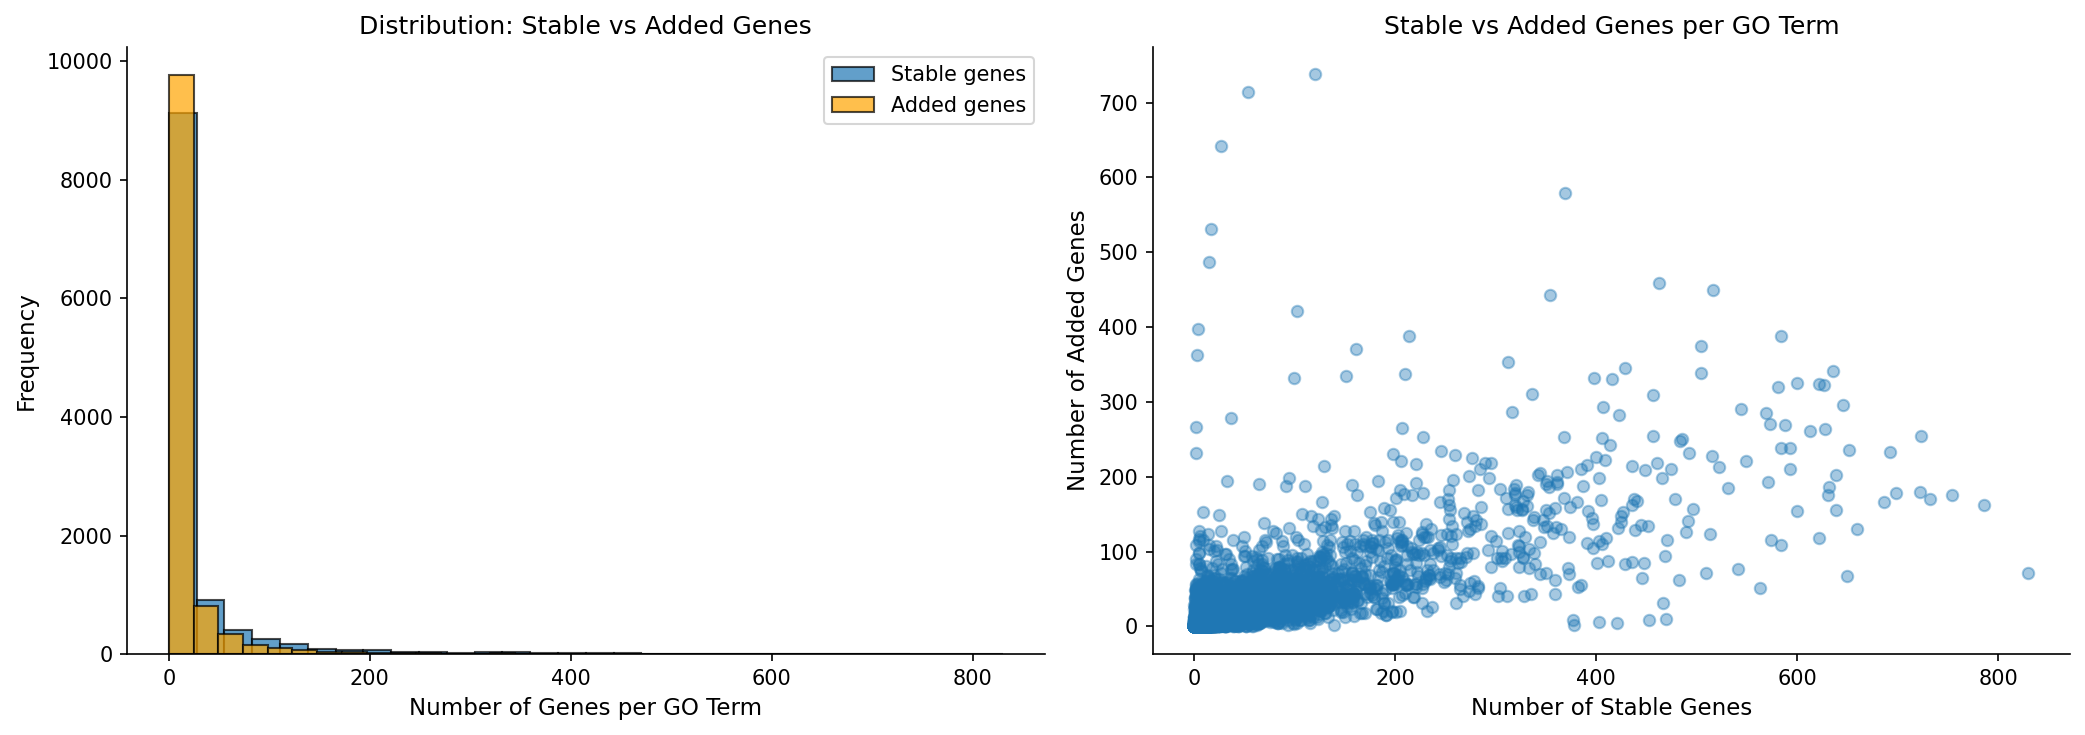

Figure saved to /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/multi-dwpc/output/images/gene_classification_stable_vs_added.pdf


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

axes[0].hist(classification_summary['n_stable'], bins=30,
             alpha=0.7, label='Stable genes', edgecolor='black')
axes[0].hist(classification_summary['n_added'], bins=30,
             alpha=0.7, label='Added genes', edgecolor='black', color='orange')
axes[0].set_xlabel('Number of Genes per GO Term', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution: Stable vs Added Genes', fontsize=12)
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].scatter(classification_summary['n_stable'],
                classification_summary['n_added'],
                alpha=0.4, s=30)
axes[1].set_xlabel('Number of Stable Genes', fontsize=11)
axes[1].set_ylabel('Number of Added Genes', fontsize=11)
axes[1].set_title('Stable vs Added Genes per GO Term', fontsize=12)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
output_images = repo_root / 'output/images'
output_images.mkdir(parents=True, exist_ok=True)
plt.savefig(output_images / 'gene_classification_stable_vs_added.pdf',
            dpi=300, bbox_inches='tight')
plt.savefig(output_images / 'gene_classification_stable_vs_added.jpeg',
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {output_images / 'gene_classification_stable_vs_added.pdf'}")

In [7]:
print("Saving classified gene datasets...")
print("=" * 60)

output_intermediate = repo_root / 'output/intermediate'
output_intermediate.mkdir(parents=True, exist_ok=True)

genes_2016_stable.to_csv(
    output_intermediate / 'hetio_bppg_2016_stable.csv',
    index=False
)
genes_2024_added.to_csv(
    output_intermediate / 'upd_go_bp_2024_added.csv',
    index=False
)
classification_summary.to_csv(
    output_intermediate / 'go_gene_classification_summary.csv',
    index=False
)

print(f"Saved: hetio_bppg_2016_stable.csv ({len(genes_2016_stable):,} pairs)")
print(f"Saved: upd_go_bp_2024_added.csv ({len(genes_2024_added):,} pairs)")
print(f"Saved: go_gene_classification_summary.csv "
      f"({len(classification_summary)} GO terms)")
print("\nGene classification complete!")

Saving classified gene datasets...


Saved: hetio_bppg_2016_stable.csv (314,466 pairs)
Saved: upd_go_bp_2024_added.csv (161,164 pairs)
Saved: go_gene_classification_summary.csv (11381 GO terms)

Gene classification complete!


In [8]:
com_go_terms_hetio_upd_go_bp_2024 = com_go_terms_hetio_upd_go_bp_2024.merge(
    classification_summary[['go_id', 'n_stable', 'n_added']],
    on='go_id',
    how='left'
)

print("Added classification counts to common_go_terms dataframe")
print(f"New columns: n_stable, n_added")
display(com_go_terms_hetio_upd_go_bp_2024.head())

Added classification counts to common_go_terms dataframe
New columns: n_stable, n_added


,go_id,no_of_genes_in_hetio_GO_2016,no_of_genes_in_GO_2024,n_stable,n_added
0,GO:0000002,25,27,23,4
1,GO:0000012,7,11,7,4
2,GO:0000018,59,131,51,80
3,GO:0000019,4,6,4,2
4,GO:0000022,9,11,8,3


In [9]:
# Calculate percent change using src function
com_go_terms_hetio_upd_go_bp_2024 = calculate_percent_change(
    com_go_terms_hetio_upd_go_bp_2024,
    count_col_2016='no_of_genes_in_hetio_GO_2016',
    count_col_2024='no_of_genes_in_GO_2024'
)

print(f"Mean change: "
      f"{com_go_terms_hetio_upd_go_bp_2024['pct_change_genes'].mean():.2f}%")
display(com_go_terms_hetio_upd_go_bp_2024.head())

Mean change: 0.44%


,go_id,no_of_genes_in_hetio_GO_2016,no_of_genes_in_GO_2024,n_stable,n_added,pct_change_genes
0,GO:0000002,25,27,23,4,0.080000
1,GO:0000012,7,11,7,4,0.571429
2,GO:0000018,59,131,51,80,1.220339
3,GO:0000019,4,6,4,2,0.500000
4,GO:0000022,9,11,8,3,0.222222


### GO Hierarchy Analysis

This section adds GO hierarchy metrics to assess whether terms at different positions in the ontology hierarchy show different patterns of annotation change over time.

**Approach:**
- Parse GO ontologies from Feb 2016 and Oct 2024
- Calculate normalized depth (depth/max_depth) for each term
- Analyze correlation between hierarchy position and percent change in annotations

**Normalized Depth Interpretation:**
- 0.0 = Root term (most general, e.g., "biological_process")
- 1.0 = Deepest term (most specific)
- Higher values = more specific/narrow terms

In [10]:
# Cache file path
cache_file = repo_root / 'output/cached_hierarchy_metrics.csv'

# Check if cached results exist
if cache_file.exists():
    print(f"Loading cached hierarchy metrics from {cache_file}")
    com_go_terms_w_hierarchy = pd.read_csv(cache_file)
    print(f"Loaded {len(com_go_terms_w_hierarchy)} GO terms from cache")
else:
    print("Calculating hierarchy metrics (this may take a few minutes)...")
    # Add hierarchy metrics to percent change data
    com_go_terms_w_hierarchy = add_hierarchy_metrics(
        com_go_terms_hetio_upd_go_bp_2024,
        obo_path_2016=str(repo_root / 'gene_ontology/gene-ontology/download/go-basic-2016-02-01.obo'),
        obo_path_2024=str(repo_root / 'gene_ontology/gene-ontology/download/go-basic.obo')
    )
    
    # Save to cache
    com_go_terms_w_hierarchy.to_csv(cache_file, index=False)
    print(f"Saved hierarchy metrics to cache: {cache_file}")
    print(f"Added hierarchy metrics to {len(com_go_terms_w_hierarchy)} GO terms")

print(f"\nColumns: {list(com_go_terms_w_hierarchy.columns)}")
print(f"\nSample data:")
display(com_go_terms_w_hierarchy[['go_id', 'pct_change_genes', 'normalized_depth_2016', 'normalized_depth_2024', 'norm_depth_change']].head(10))

# Summary statistics
print(f"\nHierarchy Statistics:")
print(f"  2016 normalized depth: {com_go_terms_w_hierarchy['normalized_depth_2016'].describe()}")
print(f"  2024 normalized depth: {com_go_terms_w_hierarchy['normalized_depth_2024'].describe()}")
print(f"  Depth change: {com_go_terms_w_hierarchy['norm_depth_change'].describe()}")

Loading cached hierarchy metrics from /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/multi-dwpc/output/cached_hierarchy_metrics.csv
Loaded 9760 GO terms from cache

Columns: ['go_id', 'no_of_genes_in_hetio_GO_2016', 'no_of_genes_in_GO_2024', 'n_stable', 'n_added', 'pct_change_genes', 'depth_2016', 'normalized_depth_2016', 'depth_2024', 'normalized_depth_2024', 'depth_change', 'norm_depth_change']

Sample data:


,go_id,pct_change_genes,normalized_depth_2016,normalized_depth_2024,norm_depth_change
0,GO:0000002,0.080000,0.416667,NaN,NaN
1,GO:0000012,0.571429,0.333333,0.461538,0.128205
2,GO:0000018,1.220339,0.500000,0.538462,0.038462
3,GO:0000019,0.500000,0.583333,0.615385,0.032051
4,GO:0000022,0.222222,0.416667,0.307692,-0.108974
5,GO:0000023,-0.333333,0.333333,0.538462,0.205128
6,GO:0000027,-0.272727,0.500000,0.538462,0.038462
7,GO:0000028,0.200000,0.500000,0.538462,0.038462
8,GO:0000038,0.206897,0.416667,0.461538,0.044872
9,GO:0000041,-0.057692,0.583333,0.538462,-0.044872



Hierarchy Statistics:
  2016 normalized depth: count    9755.000000
mean        0.456672
std         0.123753
min         0.083333
25%         0.333333
50%         0.416667
75%         0.500000
max         0.916667
Name: normalized_depth_2016, dtype: float64
  2024 normalized depth: count    9516.000000
mean        0.420773
std         0.121772
min         0.076923
25%         0.307692
50%         0.384615
75%         0.461538
max         1.000000
Name: normalized_depth_2024, dtype: float64
  Depth change: count    9511.000000
mean       -0.035961
std         0.082191
min        -0.602564
25%        -0.051282
50%        -0.032051
75%        -0.019231
max         0.448718
Name: norm_depth_change, dtype: float64


In [11]:
df_with_hierarchy = com_go_terms_w_hierarchy.dropna(
    subset=['normalized_depth_2016', 'normalized_depth_2024', 'pct_change_genes']
).copy()

print(f"Analyzing {len(df_with_hierarchy)} GO terms with complete data")

corr_2016, p_2016 = stats.spearmanr(df_with_hierarchy['normalized_depth_2016'], df_with_hierarchy['pct_change_genes'])
print(f"\nCorrelation: 2016 Normalized Depth vs Percent Change")
print(f"  Spearman r = {corr_2016:.4f}, p = {p_2016:.4e}")

corr_2024, p_2024 = stats.spearmanr(df_with_hierarchy['normalized_depth_2024'], df_with_hierarchy['pct_change_genes'])
print(f"\nCorrelation: 2024 Normalized Depth vs Percent Change")
print(f"  Spearman r = {corr_2024:.4f}, p = {p_2024:.4e}")

corr_change, p_change = stats.spearmanr(df_with_hierarchy['norm_depth_change'], df_with_hierarchy['pct_change_genes'])
print(f"\nCorrelation: Change in Normalized Depth vs Percent Change")
print(f"  Spearman r = {corr_change:.4f}, p = {p_change:.4e}")

df_with_hierarchy['depth_bin_2016'] = pd.cut(
    df_with_hierarchy['normalized_depth_2016'],
    bins=[0, 0.33, 0.67, 1.0],
    labels=['Shallow', 'Medium', 'Deep']
)
print(f"\nPercent change by 2016 depth category:")
print(df_with_hierarchy.groupby('depth_bin_2016', observed=True)['pct_change_genes'].agg(['mean', 'median', 'count']))

Analyzing 9511 GO terms with complete data

Correlation: 2016 Normalized Depth vs Percent Change
  Spearman r = 0.0620, p = 1.4049e-09

Correlation: 2024 Normalized Depth vs Percent Change
  Spearman r = 0.0545, p = 1.0538e-07

Correlation: Change in Normalized Depth vs Percent Change
  Spearman r = -0.0280, p = 6.3178e-03

Percent change by 2016 depth category:
                    mean    median  count
depth_bin_2016                           
Shallow         0.436751  0.080460    831
Medium          0.443886  0.108108   8423
Deep            0.605230  0.333333    257


There is not a clear relationship between the percent change and GO hierarchy normalized depth. 

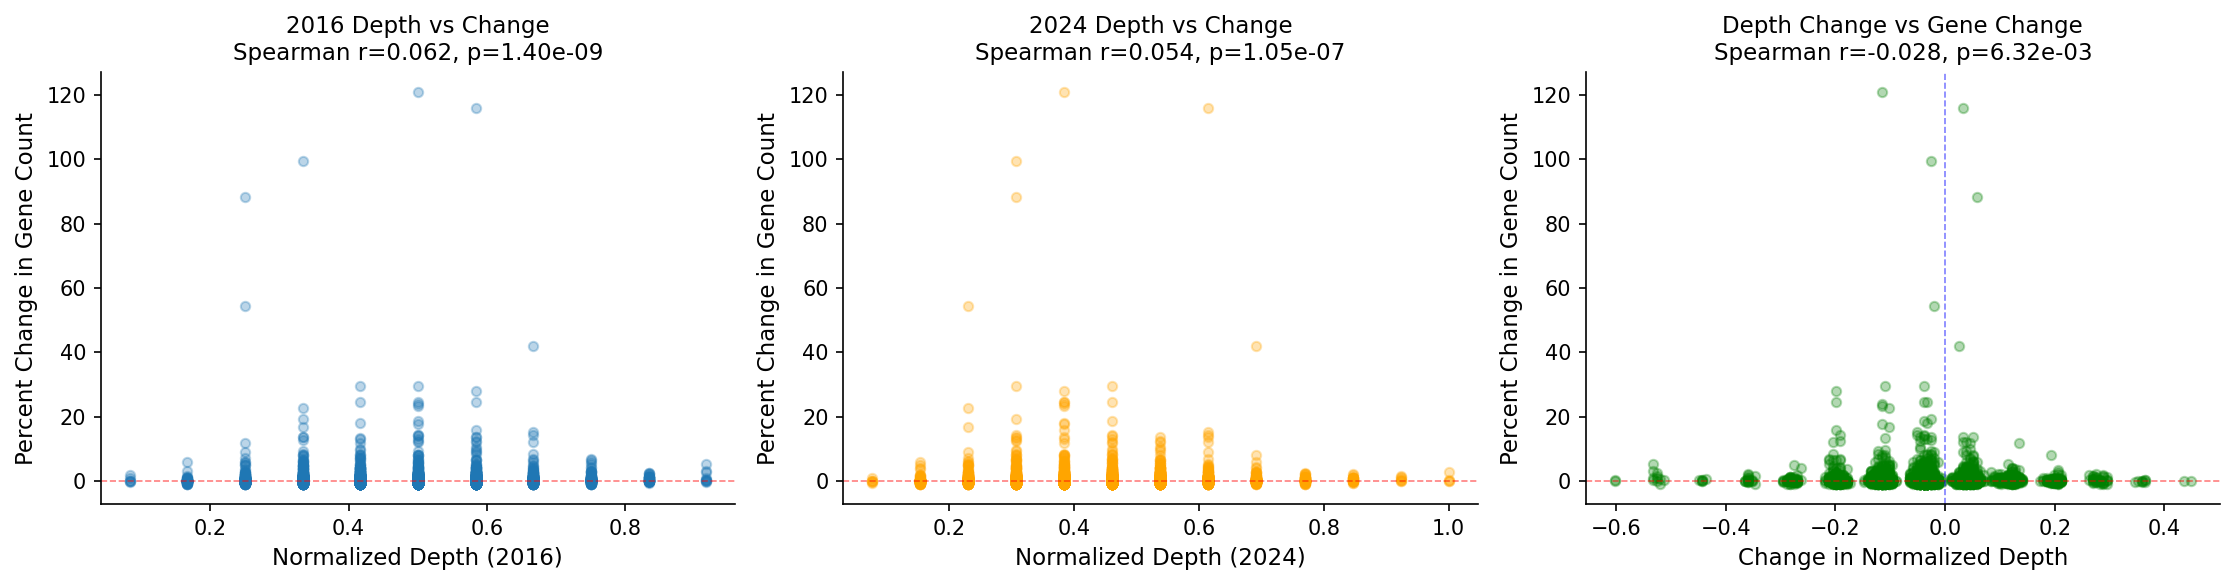


Figure saved to /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/multi-dwpc/output/images/hierarchy_vs_percent_change.pdf


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150)

# Plot 1: 2016 depth vs percent change
axes[0].scatter(df_with_hierarchy['normalized_depth_2016'], df_with_hierarchy['pct_change_genes'], alpha=0.3, s=20)
axes[0].set_xlabel('Normalized Depth (2016)', fontsize=11)
axes[0].set_ylabel('Percent Change in Gene Count', fontsize=11)
axes[0].set_title(f'2016 Depth vs Change\nSpearman r={corr_2016:.3f}, p={p_2016:.2e}', fontsize=11)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: 2024 depth vs percent change
axes[1].scatter(df_with_hierarchy['normalized_depth_2024'], df_with_hierarchy['pct_change_genes'], alpha=0.3, s=20, color='orange')
axes[1].set_xlabel('Normalized Depth (2024)', fontsize=11)
axes[1].set_ylabel('Percent Change in Gene Count', fontsize=11)
axes[1].set_title(f'2024 Depth vs Change\nSpearman r={corr_2024:.3f}, p={p_2024:.2e}', fontsize=11)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot 3: Depth change vs percent change
axes[2].scatter(df_with_hierarchy['norm_depth_change'], df_with_hierarchy['pct_change_genes'], alpha=0.3, s=20, color='green')
axes[2].set_xlabel('Change in Normalized Depth', fontsize=11)
axes[2].set_ylabel('Percent Change in Gene Count', fontsize=11)
axes[2].set_title(f'Depth Change vs Gene Change\nSpearman r={corr_change:.3f}, p={p_change:.2e}', fontsize=11)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2].axvline(x=0, color='blue', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

plt.tight_layout()
output_images = repo_root / 'output/images'
plt.savefig(output_images / 'hierarchy_vs_percent_change.pdf', dpi=300, bbox_inches='tight')
plt.savefig(output_images / 'hierarchy_vs_percent_change.jpeg', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to {output_images / 'hierarchy_vs_percent_change.pdf'}")

### Growth-Focused IQR Filter Thresholds

This section implements a two-stage filtering approach:
1. Filter to GO terms with positive annotation growth only
2. Calculate IQR thresholds from growth-only terms
3. Apply minimum gene count for statistical power

This approach focuses on GO terms that gained annotations between 2016 and 2024.

In [13]:
positive_growth_terms = com_go_terms_hetio_upd_go_bp_2024[
    com_go_terms_hetio_upd_go_bp_2024['pct_change_genes'] > 0
].copy()

print("Filter to Positive Growth Only")
print("=" * 60)
print(f"Total GO terms: {len(com_go_terms_hetio_upd_go_bp_2024)}")
print(f"Terms with positive growth: {len(positive_growth_terms)}")
print(f"Retention rate: {len(positive_growth_terms) / len(com_go_terms_hetio_upd_go_bp_2024):.1%}")
print(f"\nPercent change range:")
print(f"  Min: {positive_growth_terms['pct_change_genes'].min():.2f}%")
print(f"  Median: {positive_growth_terms['pct_change_genes'].median():.2f}%")
print(f"  Max: {positive_growth_terms['pct_change_genes'].max():.2f}%")


Filter to Positive Growth Only
Total GO terms: 9760
Terms with positive growth: 5433
Retention rate: 55.7%

Percent change range:
  Min: 0.00%
  Median: 0.43%
  Max: 121.00%


In [14]:
# Calculate IQR thresholds using src.filtering function
thresholds_growth = calculate_iqr_thresholds(positive_growth_terms)

print("IQR Thresholds (Growth-Only Terms)")
print("=" * 60)
print(f"Total terms analyzed: {thresholds_growth['total_terms']}")
print(f"\nGene Count Thresholds:")
print(f"  Min (Q25 - 1.5*IQR): {thresholds_growth['min_genes']:.0f}")
print(f"  Max (Q75 + 1.5*IQR): {thresholds_growth['max_genes']:.0f}")
print(f"  Median: {thresholds_growth['median_genes']:.0f}")
print(f"\nPercent Change Thresholds:")
print(f"  Min (Q25 - 1.5*IQR): {thresholds_growth['min_pct_change']:.2f}%")
print(f"  Max (Q75 + 1.5*IQR): {thresholds_growth['max_pct_change']:.2f}%")

IQR Thresholds (Growth-Only Terms)
Total terms analyzed: 5433

Gene Count Thresholds:
  Min (Q25 - 1.5*IQR): -37
  Max (Q75 + 1.5*IQR): 75
  Median: 11

Percent Change Thresholds:
  Min (Q25 - 1.5*IQR): -0.87%
  Max (Q75 + 1.5*IQR): 1.98%


### Identify Hierarchy Levels

Leaf terms are GO terms with no children (most specific).
Parent terms are direct parents of leaf terms (1 level up from leaves).

We identify both to create datasets at different hierarchy levels for comparison.

In [15]:
obo_path_2024 = repo_root / 'gene_ontology/gene-ontology/download/go-basic.obo'

# Cache files
leaf_cache = repo_root / 'output/cached_leaf_terms_2024.txt'
parent_cache = repo_root / 'output/cached_parent_terms_2024.txt'

# Check if cached results exist
if leaf_cache.exists() and parent_cache.exists():
    print("Loading cached leaf and parent terms...")
    with open(leaf_cache, 'r') as f:
        leaf_terms_2024 = set(line.strip() for line in f)
    with open(parent_cache, 'r') as f:
        parent_terms_2024 = set(line.strip() for line in f)
    print(f"Loaded {len(leaf_terms_2024)} leaf terms and {len(parent_terms_2024)} parent terms from cache")
else:
    print("Calculating leaf and parent terms (this may take a minute)...")
    leaf_terms_2024 = identify_leaf_terms(str(obo_path_2024), namespace='biological_process')
    parent_terms_2024 = identify_parent_terms(leaf_terms_2024, str(obo_path_2024), namespace='biological_process')
    
    # Save to cache
    with open(leaf_cache, 'w') as f:
        f.write('\n'.join(sorted(leaf_terms_2024)))
    with open(parent_cache, 'w') as f:
        f.write('\n'.join(sorted(parent_terms_2024)))
    print(f"Saved leaf/parent terms to cache")

print(f"Total leaf terms identified: {len(leaf_terms_2024)}")
print(f"Total parent terms (1 level up): {len(parent_terms_2024)}")

# Check how many of our positive-growth terms are leaves vs parents
leaf_in_growth = len(set(positive_growth_terms['go_id']) & leaf_terms_2024)
parent_in_growth = len(set(positive_growth_terms['go_id']) & parent_terms_2024)

print(f"\nIn our positive-growth terms:")
print(f"  Leaf terms: {leaf_in_growth}")
print(f"  Parent terms: {parent_in_growth}")

Loading cached leaf and parent terms...
Loaded 13751 leaf terms and 9220 parent terms from cache
Total leaf terms identified: 13751
Total parent terms (1 level up): 9220

In our positive-growth terms:
  Leaf terms: 1566
  Parent terms: 2861


### Create Two Filtered Datasets

Dataset 1: All GO terms with positive growth, within IQR, and at least 10 genes
Dataset 2: Parents of leaf terms (1 level up) with same filters

Both datasets focus on GO terms with annotation growth and adequate sample size for mixed-effects models.

In [16]:
# Create filtered datasets using src.filtering function
dataset1_all_growth = filter_go_terms_iqr(
    positive_growth_terms,
    thresholds_growth,
    min_genes=10
)

# Create hierarchy-level subsets
dataset2_leaves = dataset1_all_growth[
    dataset1_all_growth['go_id'].isin(leaf_terms_2024)
].reset_index(drop=True)

dataset2_parents = dataset1_all_growth[
    dataset1_all_growth['go_id'].isin(parent_terms_2024)
].reset_index(drop=True)

print("Dataset 1: All Terms (Growth + IQR + Min Genes)")
print("=" * 60)
print(f"Filtered GO terms: {len(dataset1_all_growth)}")
print(f"Mean gene count (2016): "
      f"{dataset1_all_growth['no_of_genes_in_hetio_GO_2016'].mean():.1f}")
print(f"Median gene count (2016): "
      f"{dataset1_all_growth['no_of_genes_in_hetio_GO_2016'].median():.0f}")

print(f"\nDataset 2a: Leaf Terms (most specific)")
print("=" * 60)
print(f"GO terms: {len(dataset2_leaves)}")
print(f"Mean gene count (2016): "
      f"{dataset2_leaves['no_of_genes_in_hetio_GO_2016'].mean():.1f}")
print(f"Median gene count (2016): "
      f"{dataset2_leaves['no_of_genes_in_hetio_GO_2016'].median():.0f}")
print(f"Retention from dataset1: "
      f"{len(dataset2_leaves) / len(dataset1_all_growth):.1%}")

print(f"\nDataset 2b: Parent Terms (1 level up from leaves)")
print("=" * 60)
print(f"GO terms: {len(dataset2_parents)}")
print(f"Mean gene count (2016): "
      f"{dataset2_parents['no_of_genes_in_hetio_GO_2016'].mean():.1f}")
print(f"Median gene count (2016): "
      f"{dataset2_parents['no_of_genes_in_hetio_GO_2016'].median():.0f}")
print(f"Retention from dataset1: "
      f"{len(dataset2_parents) / len(dataset1_all_growth):.1%}")



Dataset 1: All Terms (Growth + IQR + Min Genes)
Filtered GO terms: 2161
Mean gene count (2016): 27.5
Median gene count (2016): 22

Dataset 2a: Leaf Terms (most specific)
GO terms: 456
Mean gene count (2016): 23.3
Median gene count (2016): 17
Retention from dataset1: 21.1%

Dataset 2b: Parent Terms (1 level up from leaves)
GO terms: 1244
Mean gene count (2016): 28.1
Median gene count (2016): 23
Retention from dataset1: 57.6%


Parent terms better capture the mean/median gene counts of the full dataset. Therefore, moving forward with Parent terms.

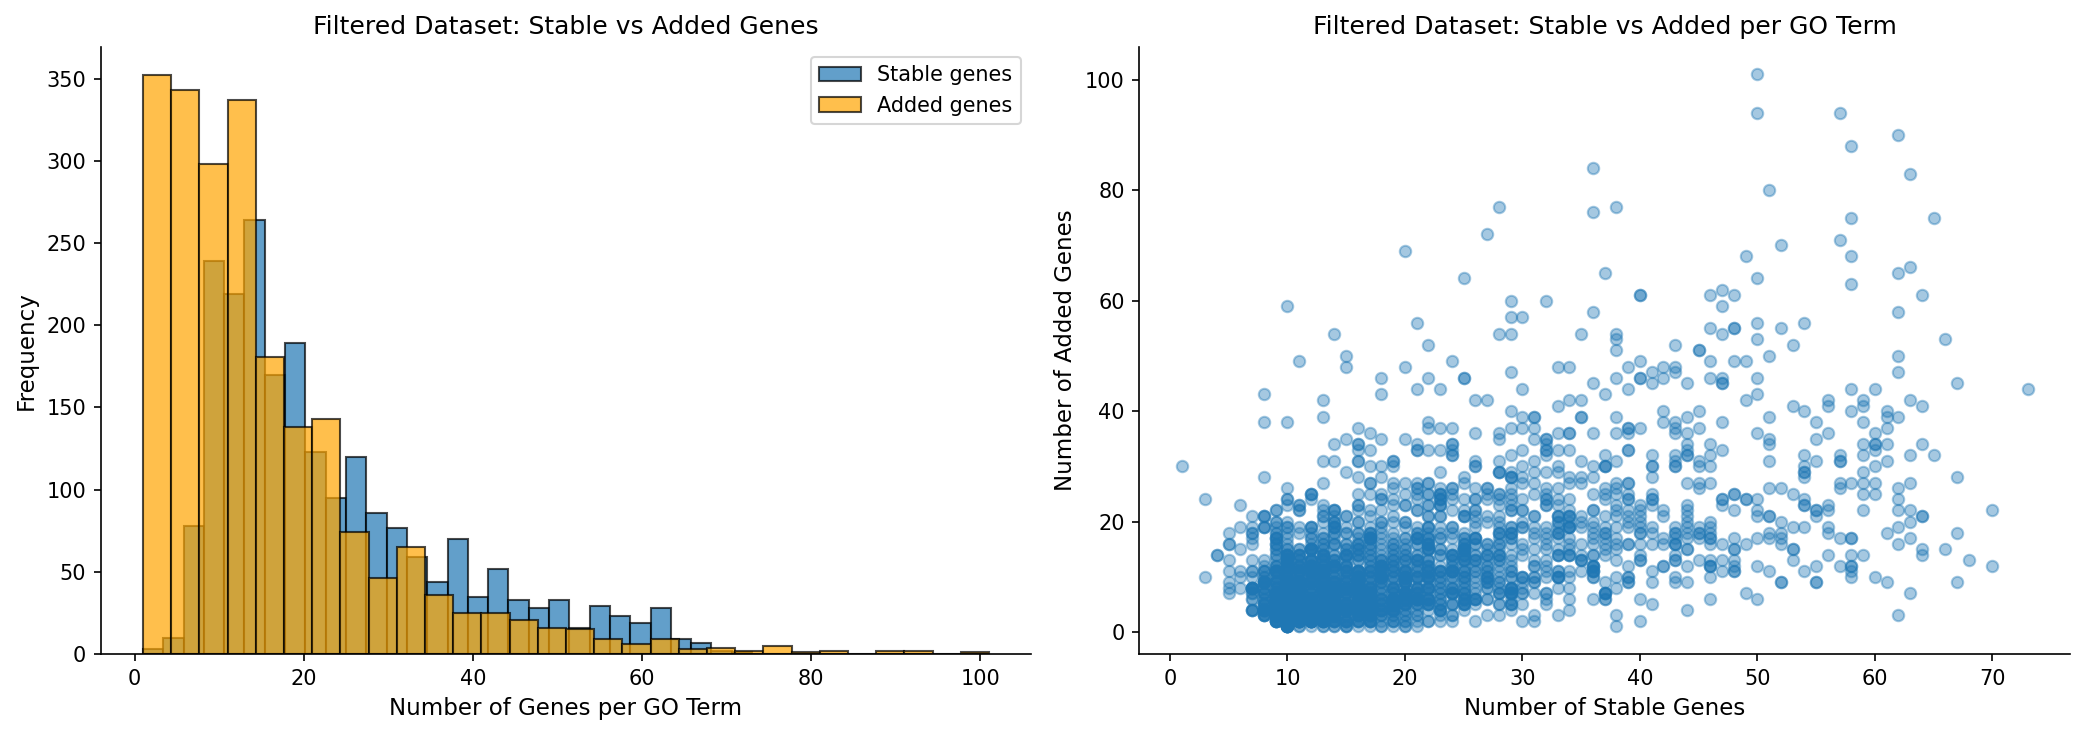

Figure saved to /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/multi-dwpc/output/images/filtered_dataset_stable_vs_added.pdf


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

axes[0].hist(dataset1_all_growth['n_stable'], bins=30, 
             alpha=0.7, label='Stable genes', edgecolor='black')
axes[0].hist(dataset1_all_growth['n_added'], bins=30, 
             alpha=0.7, label='Added genes', edgecolor='black', color='orange')
axes[0].set_xlabel('Number of Genes per GO Term', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Filtered Dataset: Stable vs Added Genes', fontsize=12)
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].scatter(dataset1_all_growth['n_stable'],
                dataset1_all_growth['n_added'],
                alpha=0.4, s=30)
axes[1].set_xlabel('Number of Stable Genes', fontsize=11)
axes[1].set_ylabel('Number of Added Genes', fontsize=11)
axes[1].set_title('Filtered Dataset: Stable vs Added per GO Term', fontsize=12)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
output_images = repo_root / 'output/images'
plt.savefig(output_images / 'filtered_dataset_stable_vs_added.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(output_images / 'filtered_dataset_stable_vs_added.jpeg', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {output_images / 'filtered_dataset_stable_vs_added.pdf'}")

### Summary

Two datasets created using growth-focused IQR filtering:

1. Dataset 1: All GO terms with positive growth, IQR filtering, and at least 10 genes per term
2. Dataset 2: Parents of leaf terms (1 level up) with same filters

Rationale:
- Positive growth filter: Focuses on GO terms gaining annotations between 2016 and 2024
- IQR on growth-only: Removes outliers among growing terms specifically
- Min 10 genes: Ensures adequate statistical power 
- Parents of leaves: More genes than leaves, still specific, one consistent hierarchy level up

Both datasets will be processed through the downstream analysis pipeline to validate that results are robust to hierarchy level selection. If both show the same patterns, findings are not artifacts of term specificity or generality.

In [18]:
# Save outputs
output_intermediate = repo_root / 'output/intermediate'
dataset1_all_growth.to_csv(
    output_intermediate / 'dataset1_all_growth.csv',
    index=False
)
dataset2_parents.to_csv(
    output_intermediate / 'dataset2_parents.csv',
    index=False
)

print(f'Saved dataset1_all_growth: {len(dataset1_all_growth)} GO terms')
print(f'Saved dataset2_parents: {len(dataset2_parents)} GO terms')
print('\nNotebook 1.2 complete!')

Saved dataset1_all_growth: 2161 GO terms
Saved dataset2_parents: 1244 GO terms

Notebook 1.2 complete!
